# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_


### By Zhonghao Wang( zw2865 ) and Yanyi Wang (yw3949)

 This part we are setting up the notebook by importing necessary libraries and installing packages

## Project Setup

In [1]:
# all import statements needed for the project:

import math
import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import re
import os
import glob
import stat
import scipy.stats as st
import warnings
import ipywidgets as widgets
import cufflinks as cf
from ipywidgets import interact, interact_manual
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
cf.go_offline()
warnings.filterwarnings("ignore")

In [2]:
#Global Variables needed for the projects:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
TAXI_ZONES = "taxi_zones/taxi_zones.shp"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
WEATHER_PATH = "weather"
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
#load shp file and get coordinations of pickup and dropoff location
taxi_zones_df = gpd.read_file(TAXI_ZONES)
taxi_zones_df = taxi_zones_df.to_crs(4326)
taxi_zones_df['lon'] = taxi_zones_df.centroid.x  
taxi_zones_df['lat'] = taxi_zones_df.centroid.y

## Part 1: Data Preprocessing

In part 1 we 
1. Calculates the distance between two coordinates in kilometers
2. Download all yellow taxi trip data from nyc government webiste using web scraping.
3. Load and clean the yellow taxi data for each month from 2009/01 to 2015/06
4. Load and clean the uber data.
5. Load and clean the weather data from 2009 to 2015.

### Calculating distance
We defined a function that calculates the distance between two coordinates in kilometers that using latitude and lontitue corrdination. 

In [4]:
def calculate_distance(from_coord, to_coord):
    """
    This function calculated distance from one coordination to another
    
    Parameters: from_coord:input pickup location lon and lat coordinations dataframe
                to_coord: input dropoff location lon and lat coordinations dataframe
    return: distance in km
    
    """
    # convert longitude and latitude to radian
    lon1, lat1, lon2, lat2 = map(math.radians, from_coord+to_coord) 
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    distance=2*math.asin(math.sqrt(a))* 6371*1000
    distance=round(distance/1000,3)
    return distance

### Create a new column 
We defined a function that create a new column called distance in the dataframe and calculated distance for 
each row in the dataframe for columns that contain pickup latitude lontitude and drop off lat and lon.The result distance will be the distance in kilometers between pick up coordination and drop off coordination

In [5]:
def add_distance_column(dataframe):
    """
    This function add distance column to dataframe 
    
    Parameters: dataframe contains pick up drop off lat and lon coordinates
    return: new dataframe
    
    """
    
    dataframe['distance'] = dataframe.apply(lambda x: calculate_distance((
        x['pickup_longitude'], x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])), axis=1)
    return dataframe

### Processing Taxi Data
1. We use request to scrap the webiste of nyc govnment to get Yellow Taxi Trip Records data by first get all links of data for each month from 2009/01 to 2015/06 by find_taxi_parquet_urls(taxi_url) funciton 
2. After we get all the links for data, we used get_month_taxi_data(taxi_data_url) to download all the taxt data      files
3. We clean the data for each month by removing unnecessary columns, renaming some columns and delete some trips      that are not of our interest by clean_month_taxi_data(raw_taxi_data,taxi_zones) function
4. get_and_clean_taxi_data() is getting the cleaned taxt data we are going to use for later parts of the project,    we also did some sampling to match the number of data with Uber date we are going to use next.

In [6]:
def find_taxi_parquet_urls(taxi_url):
    """
    This function finds urls of the parquet files. 
    
    Parameters: taxi_url : the website contains all links parquet files
    
    return: a list of parquet file urls 
    
    """
    response = requests.get(taxi_url)
    html = response.content
    results_page = bs4.BeautifulSoup(html, 'html.parser')
    links = results_page.find_all('a',title=r'Yellow Taxi Trip Records')
    pattern = r'yellow_tripdata_(2009|201[0-4]|2015-0[1-6])'
    urls = [link.get('href') for link in links if re.search(pattern,link.get('href'))]
    return urls

In [7]:
def get_month_taxi_data(taxi_data_url):
    """
    This function download and get all taxi data from each month  
    
    Parameters: taxi_data_url : a link to the file contain taxi data of one month 
    
    return: a dataframe contain this month data 
    
    """
    pattern = r'yellow_tripdata_[0-9]{4}-[0-9]{2}'
    name = re.search(pattern,taxi_data_url).group()
    path = os.path.join(os.getcwd(),'taxi',name+'.csv')
    if os.path.exists(path):
        print('read',name)
        df = pd.read_csv(path)
    else:
        print('download',name)
        df = pd.read_parquet(taxi_data_url, engine='pyarrow')
        df.to_csv(path)
    return df

In [8]:
def clean_month_taxi_data(raw_taxi_data,taxi_zones):
    """
    This function clean all taxi data from each month  
    
    Parameters: raw_taxi_data : raw data before cleaning 
                taxi_zones: dataframe we get that contains pickup,dropoff lat and lon
    
    return: a cleaned dataframe contain this month data 
    
    """
    taxi_data = pd.DataFrame()
    if 'tpep_pickup_datetime' in raw_taxi_data.columns:
        taxi_data['pickup_datetime'] = raw_taxi_data['tpep_pickup_datetime']
    elif 'Trip_Pickup_DateTime' in raw_taxi_data.columns:
        taxi_data['pickup_datetime'] = raw_taxi_data['Trip_Pickup_DateTime']
    elif 'pickup_datetime' in raw_taxi_data.columns:
        taxi_data['pickup_datetime'] = raw_taxi_data['pickup_datetime']
    else:
        raise ValueError('No pickup_datetime')
    if 'PULocationID' and 'DOLocationID' in raw_taxi_data.columns:
        taxi_data['PULocationID'] = raw_taxi_data['PULocationID']
        taxi_data['DOLocationID'] = raw_taxi_data['DOLocationID']
        taxi_data = taxi_data.merge(taxi_zones[['LocationID','lon','lat']].set_index('LocationID'),
                                    left_on='PULocationID', right_on='LocationID')
        taxi_data = taxi_data.rename(columns={'lon': 'pickup_longitude', 'lat': 'pickup_latitude'})
        taxi_data = taxi_data.merge(taxi_zones[['LocationID','lon','lat']].set_index('LocationID'),
                                    left_on='DOLocationID', right_on='LocationID')
        taxi_data = taxi_data.rename(columns={'lon': 'dropoff_longitude', 'lat': 'dropoff_latitude'})

        taxi_data = taxi_data.drop(columns=['PULocationID','DOLocationID'])
    elif 'Start_Lon' and 'Start_Lat' and 'End_Lon' and 'End_Lat' in raw_taxi_data.columns:
        taxi_data['pickup_longitude'] = raw_taxi_data['Start_Lon']
        taxi_data['pickup_latitude'] = raw_taxi_data['Start_Lat']
        taxi_data['dropoff_longitude'] = raw_taxi_data['End_Lon']
        taxi_data['dropoff_latitude'] = raw_taxi_data['End_Lat']
    elif 'pickup_longitude' and 'pickup_latitude' and 'dropoff_longitude' and 'dropoff_latitude' in raw_taxi_data.columns:
        taxi_data['pickup_longitude'] = raw_taxi_data['pickup_longitude']
        taxi_data['pickup_latitude'] = raw_taxi_data['pickup_latitude']
        taxi_data['dropoff_longitude'] = raw_taxi_data['dropoff_longitude']
        taxi_data['dropoff_latitude'] = raw_taxi_data['dropoff_latitude']
    else:
        raise ValueError('No pickup_datetime')

    taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
    taxi_data = taxi_data.dropna()
    
    
    #pick up in bounding box 
    taxi_data = taxi_data[(taxi_data['pickup_longitude']>NEW_YORK_BOX_COORDS[0][1])
                          & (taxi_data['pickup_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    taxi_data = taxi_data[(taxi_data['pickup_latitude']>NEW_YORK_BOX_COORDS[0][0])
                          & (taxi_data['pickup_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    #drop off in bounding box  
    taxi_data = taxi_data[(taxi_data['dropoff_longitude']>NEW_YORK_BOX_COORDS[0][1])
                          & (taxi_data['dropoff_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    taxi_data = taxi_data[(taxi_data['dropoff_latitude']>NEW_YORK_BOX_COORDS[0][0])
                          & (taxi_data['dropoff_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    if 'Tip_Amt'  in raw_taxi_data.columns:
        taxi_data['tip_amount'] = raw_taxi_data['Tip_Amt']
       
        
    elif  'tip_amount' in raw_taxi_data.columns:
         taxi_data['tip_amount'] = raw_taxi_data['tip_amount']
    
    return taxi_data

In [9]:
def get_and_clean_taxi_data(taxi_zones):
    """
    This function get and load and clean by calling functions we created above  
    
    Parameters: taxi_zones: dataframe we get that contains pickup,dropoff lat and lon
    
    return: A dataframe contain all taxi data we need 
    
    """
    
    all_csv_urls = find_taxi_parquet_urls(TAXI_URL)
    all_taxi_dataframes = []
    for csv_url in all_csv_urls:
        month_taxi_dataframe = get_month_taxi_data(csv_url)
        month_taxi_dataframe = clean_month_taxi_data(month_taxi_dataframe,taxi_zones)
        month_taxi_dataframe = add_distance_column(month_taxi_dataframe)
        all_taxi_dataframes.append(month_taxi_dataframe.sample(2600,random_state=1))
        
    # create one gigantic dataframe with data from every month needed
    all_taxi_data = pd.concat(all_taxi_dataframes)
    all_taxi_data = all_taxi_data.sample(200000,random_state=1)
    return all_taxi_data

### Processing Uber Data
1. We clean the uber data by removing unnecessary columns, renaming some columns and delete some trips that are not in bound of nyc by clean_uber_data(csv_file) function
4. get_uber_data() is getting the cleaned taxt data we are going to use for later parts of the project

In [10]:
def clean_uber_data(csv_file):
    """
    This function get and load and clean uber data   
    
    Parameters: csv_file: the file path of uber data 
    
    return: uber data in a dataframe we need 
    
    """
    uber_data = pd.read_csv(csv_file)
    uber_data = uber_data.drop(columns=['Unnamed: 0','key','fare_amount','passenger_count'])
    uber_data = uber_data.dropna()
    
    #pick up in bounding box 
    uber_data = uber_data[(uber_data['pickup_longitude']>NEW_YORK_BOX_COORDS[0][1]) & (uber_data['pickup_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    uber_data = uber_data[(uber_data['pickup_latitude']>NEW_YORK_BOX_COORDS[0][0]) & (uber_data['pickup_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    #drop off in bounding box  
    uber_data = uber_data[(uber_data['dropoff_longitude']>NEW_YORK_BOX_COORDS[0][1]) & (uber_data['dropoff_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    uber_data = uber_data[(uber_data['dropoff_latitude']>NEW_YORK_BOX_COORDS[0][0]) & (uber_data['dropoff_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])
    
    return uber_data

In [11]:
def get_uber_data():
    """
    This function get and load and clean uber data by calling functions above 
    and add distance between coordinates
    
    Parameters: 
    
    return: all uber data in a dataframe we need 
    
    """
    uber_dataframe = clean_uber_data(UBER_CSV)
    uber_dataframe = add_distance_column(uber_dataframe)
    return uber_dataframe

Get all the uber_data in a dataframe by calling function we defined above

### Processing Weather Data

1. We clean the weather data by removing unnecessary columns, renaming some columns and get hourly, daily weather data using clean_month_weather_data_hourly(csv_file) and clean_month_weather_data_daily(csv_file) functions.
4.  We use load_and_clean_weather_data()to load and put everything in a single dataframe.

In [12]:
def clean_month_weather_data_hourly(csv_file):
    """
    This function get and load and clean hourly weather data   
    
    Parameters: csv_file: the file path of wather data 
    
    return: hourly weather data in a dataframe  
    
    """
    whole_data = pd.read_csv(csv_file)
    whole_data['REPORT_TYPE'] = whole_data['REPORT_TYPE'].astype(str)
    whole_data['DATE'] = pd.to_datetime(whole_data['DATE'])
    
    hourly_data = whole_data[whole_data['REPORT_TYPE'] != 'SOD  ']
    hourly_data = hourly_data[['DATE','HourlyPrecipitation','HourlyWindSpeed']]
    hourly_data['HourlyPrecipitation'] = pd.to_numeric(hourly_data['HourlyPrecipitation'], errors='coerce')
    hourly_data['HourlyWindSpeed'] = pd.to_numeric(hourly_data['HourlyWindSpeed'], errors='coerce')
    hourly_data['HourlyPrecipitation'].fillna(0, inplace=True)
    hourly_data['HourlyWindSpeed'].fillna(0, inplace=True)
    hourly_data = hourly_data.rename(columns={'DATE': 'datetime'})
    hourly_data = hourly_data.rename(columns={'HourlyPrecipitation':'hourly_precipitation','HourlyWindSpeed':'hourly_wind_speed'})
    
    return hourly_data

In [13]:
def clean_month_weather_data_daily(csv_file):
    """
    This function get and load and clean daily weather data   
    
    Parameters: csv_file: the file path of weather data 
    
    return: daily data in a dataframe we need 
    
    """
    whole_data = pd.read_csv(csv_file)
    whole_data['REPORT_TYPE'] = whole_data['REPORT_TYPE'].astype(str)
    whole_data['DATE'] = pd.to_datetime(whole_data['DATE'])
    whole_data['DATE'] = whole_data['DATE'].dt.date
    
    hourly_data = whole_data[whole_data['REPORT_TYPE'] != 'SOD  ']
    hourly_data = hourly_data[['DATE','HourlyPrecipitation','HourlyWindSpeed']]
    hourly_data['HourlyPrecipitation'] = pd.to_numeric(hourly_data['HourlyPrecipitation'], errors='coerce')
    hourly_data['HourlyWindSpeed'] = pd.to_numeric(hourly_data['HourlyWindSpeed'], errors='coerce')
    hourly_data['HourlyPrecipitation'].fillna(0, inplace=True)
    hourly_data = hourly_data.groupby('DATE', as_index=False).agg({'HourlyWindSpeed': 'mean', 'HourlyPrecipitation': 'sum'})
    
    daily_data = whole_data[whole_data['REPORT_TYPE'] == 'SOD  ']
    daily_data = daily_data[['DATE','Sunrise','Sunset']]
    daily_data['Sunrise'] = pd.to_numeric(daily_data['Sunrise'], errors='coerce')
    daily_data['Sunset'] = pd.to_numeric(daily_data['Sunset'], errors='coerce')
    
    daily_data = hourly_data.merge(daily_data, on='DATE',how='left')
    daily_data.fillna(method='ffill',inplace=True)
    daily_data.fillna(method='bfill',inplace=True)
    daily_data = daily_data.rename(columns={'DATE': 'date'})
    daily_data = daily_data.rename(columns={'HourlyPrecipitation':'daily_precipitation', 'HourlyWindSpeed':'daily_wind_speed'})
    daily_data = daily_data.rename(columns={'Sunrise': 'sunrise', 'Sunset': 'sunset'})
    
    return daily_data

In [14]:
def load_and_clean_weather_data():
    """
    This function load and clean daily and hourly weather data   
    
    Parameters:
    
    return: daily and hourly weather data in two dataframes
    
    """
    hourly_dataframes = []
    daily_dataframes = []
    
    weather_csv_files = glob.glob(os.path.join(os.getcwd(), WEATHER_PATH, "*.csv"))
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

This is executing all the functions and get taxi_data, uber_data and hourly, daily weather data.


In [15]:
taxi_data = get_and_clean_taxi_data(taxi_zones_df)
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

read yellow_tripdata_2015-01
read yellow_tripdata_2015-02
read yellow_tripdata_2015-03
read yellow_tripdata_2015-04
read yellow_tripdata_2015-05
read yellow_tripdata_2015-06
read yellow_tripdata_2014-01
read yellow_tripdata_2014-02
read yellow_tripdata_2014-03
read yellow_tripdata_2014-04
read yellow_tripdata_2014-05
read yellow_tripdata_2014-06
read yellow_tripdata_2014-07
read yellow_tripdata_2014-08
read yellow_tripdata_2014-09
read yellow_tripdata_2014-10
read yellow_tripdata_2014-11
read yellow_tripdata_2014-12
read yellow_tripdata_2013-01
read yellow_tripdata_2013-02
read yellow_tripdata_2013-03
read yellow_tripdata_2013-04
read yellow_tripdata_2013-05
read yellow_tripdata_2013-06
read yellow_tripdata_2013-07
read yellow_tripdata_2013-08
read yellow_tripdata_2013-09
read yellow_tripdata_2013-10
read yellow_tripdata_2013-11
read yellow_tripdata_2013-12
read yellow_tripdata_2012-01
read yellow_tripdata_2012-02
read yellow_tripdata_2012-03
read yellow_tripdata_2012-04
read yellow_tr

## Part 2: Storing Cleaned Data

We then store all the cleaned data in to database, we used SQL to create tables for each dataframe we created.

In [16]:
engine = db.create_engine(DATABASE_URL)

In [17]:
# using SQL to create 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    datetime DATETIME,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    date DATE,
    daily_wind_speed FLOAT,
    daily_precipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
    tip_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

SUN_DATA_SCHEMA = """CREATE TABLE IF NOT EXISTS sun_data (
    id INTEGER PRIMARY KEY,
    date DATE,
    sunrise INT32,
    sunset INT32
);
"""

In [18]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [19]:
# create the tables with the schema files
with engine.connect() as connection:
    sql = open(DATABASE_SCHEMA_FILE, "r")
    commands = sql.read().split(";")
    sql.close()
    for command in commands:
        connection.execute(command)

### Add Data to Database

After we create the table we add it with data from dataframe we created above

In [20]:
def write_dataframes_to_table(table_to_df_dict):
    """
    This function input data from dataframe to sql table
    Parameters:a dictionary contain all dataframes and corresponding table
    
    """
    for name, table in table_to_df_dict.items():
        table.to_sql(name, engine, if_exists='replace', index=False)

In [21]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data[['date', 'daily_wind_speed', 'daily_precipitation']],
    "sun_data": daily_weather_data[['date', 'sunrise', 'sunset']]
}

In [22]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

This function is getting data by query and write it to a file with filename outfile 

In [23]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query 1

After we stored the data, we can query to answer several question of interests

For 01-2009 through 06-2015, this query is finding hour of the day was the most popular to take a yellow taxi

In [24]:
QUERY_1 = """
SELECT strftime('%H', pickup_datetime) AS time, COUNT(*) AS number
FROM taxi_trips
GROUP BY time
ORDER BY number DESC;
"""

In [25]:
engine.execute(QUERY_1).fetchall()

[('19', 12463),
 ('18', 11955),
 ('20', 11708),
 ('21', 11542),
 ('22', 11118),
 ('14', 10339),
 ('13', 9876),
 ('23', 9826),
 ('12', 9825),
 ('17', 9804),
 ('15', 9675),
 ('11', 9329),
 ('09', 9161),
 ('08', 9146),
 ('10', 9086),
 ('16', 8305),
 ('00', 7894),
 ('07', 7142),
 ('01', 5767),
 ('02', 4397),
 ('06', 4065),
 ('03', 3239),
 ('04', 2316),
 ('05', 2022)]

In [26]:
write_query_to_file(QUERY_1, "most_popular_hour.sql")

### Query 2
For the same time frame, this query finds what day of the week was the most popular to take an uber

In [27]:
QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS number
FROM uber_trips
GROUP BY day
ORDER BY number DESC;
"""

In [28]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [29]:
write_query_to_file(QUERY_2, "most_popular_day.sql")

### Query 3
This query is finding What is the 95% percentile of distance traveled for all hired trips during July 2013

In [30]:
QUERY_3 = """
WITH hired_trips AS
(
    SELECT pickup_datetime, distance FROM taxi_trips 
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
)
SELECT distance
FROM hired_trips
ORDER BY distance
LIMIT 1
OFFSET (SELECT COUNT(*) FROM hired_trips) * 95 / 100 - 1 ;
"""

In [31]:
engine.execute(QUERY_3).fetchall()

[(9.972,)]

In [32]:
write_query_to_file(QUERY_3, "95%_percentile_distance.sql")

### Query 4
 This query is finding What were the top 10 days with the highest number of hired rides for 2009, 
 and what was the average distance for each day.
 

In [33]:
QUERY_4 = """
WITH hired_trips AS
(
    SELECT pickup_datetime, distance FROM taxi_trips 
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
)
SELECT DATE(pickup_datetime) AS date, COUNT(*) AS number, printf("%.4f",AVG(distance)) AS avg_distance
FROM hired_trips
GROUP BY date
ORDER BY number DESC
LIMIT 10;
"""

In [34]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 254, '2.9130'),
 ('2009-08-14', 224, '3.3252'),
 ('2009-05-16', 219, '2.9676'),
 ('2009-12-05', 218, '3.1854'),
 ('2009-06-05', 216, '2.8281'),
 ('2009-02-20', 216, '2.9317'),
 ('2009-10-23', 213, '2.8904'),
 ('2009-12-18', 212, '2.9511'),
 ('2009-05-21', 209, '3.3974'),
 ('2009-03-11', 209, '2.7878')]

In [35]:
write_query_to_file(QUERY_4, "top_10_days.sql")

### Query 5
Query 5 is getting Which 10 days in 2014 were the windiest, and how many hired trips were made on those days.

In [36]:
QUERY_5 = """
WITH hired_trips AS
(
    SELECT DATE(pickup_datetime) AS date FROM taxi_trips
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
    UNION ALL
    SELECT DATE(pickup_datetime) AS date FROM uber_trips
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
)
SELECT hired_trips.date as date, printf("%.4f",daily_wind_speed), COUNT(*) AS number
FROM hired_trips
JOIN daily_weather ON hired_trips.date = DATE(daily_weather.date)
GROUP BY hired_trips.date
ORDER BY daily_wind_speed DESC
LIMIT 10
"""

In [37]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', '14.0000', 202),
 ('2014-01-07', '13.0833', 175),
 ('2014-01-02', '12.7273', 135),
 ('2014-02-13', '12.2264', 138),
 ('2014-03-26', '11.9545', 178),
 ('2014-03-29', '11.9149', 189),
 ('2014-12-07', '11.6000', 153),
 ('2014-12-09', '11.2692', 167),
 ('2014-12-08', '11.2667', 151),
 ('2014-11-02', '10.8261', 153)]

In [38]:
write_query_to_file(QUERY_5, "windiest_10_days.sql")

### Query 6
This query is finding that during Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [39]:
QUERY_6 = """
WITH hired_trips AS
(
    SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS trip_hour FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31'
    UNION ALL
    SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS trip_hour FROM uber_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31'
),
hurricane_weather AS
(
    SELECT strftime('%Y-%m-%d %H',datetime) AS weather_hour, hourly_precipitation, hourly_wind_speed FROM hourly_weather
    WHERE datetime BETWEEN '2012-10-22' AND '2012-10-31'
)
SELECT weather_hour, COALESCE(COUNT(trip_hour),0) AS number, hourly_precipitation, hourly_wind_speed
FROM hurricane_weather
LEFT JOIN hired_trips
ON trip_hour = weather_hour
GROUP BY weather_hour
"""

In [40]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 4, 0.0, 7.0),
 ('2012-10-22 01', 0, 0.0, 5.0),
 ('2012-10-22 02', 3, 0.0, 7.0),
 ('2012-10-22 03', 1, 0.0, 0.0),
 ('2012-10-22 04', 0, 0.0, 0.0),
 ('2012-10-22 05', 3, 0.0, 0.0),
 ('2012-10-22 06', 8, 0.0, 5.0),
 ('2012-10-22 07', 8, 0.0, 3.0),
 ('2012-10-22 08', 4, 0.0, 3.0),
 ('2012-10-22 09', 12, 0.0, 5.0),
 ('2012-10-22 10', 6, 0.0, 0.0),
 ('2012-10-22 11', 9, 0.0, 0.0),
 ('2012-10-22 12', 7, 0.0, 11.0),
 ('2012-10-22 13', 12, 0.0, 0.0),
 ('2012-10-22 14', 6, 0.0, 7.0),
 ('2012-10-22 15', 3, 0.0, 6.0),
 ('2012-10-22 16', 8, 0.0, 3.0),
 ('2012-10-22 17', 9, 0.0, 7.0),
 ('2012-10-22 18', 13, 0.0, 5.0),
 ('2012-10-22 19', 11, 0.0, 5.0),
 ('2012-10-22 20', 7, 0.0, 3.0),
 ('2012-10-22 21', 7, 0.0, 0.0),
 ('2012-10-22 22', 9, 0.0, 3.0),
 ('2012-10-22 23', 1, 0.0, 3.0),
 ('2012-10-23 00', 4, 0.0, 3.0),
 ('2012-10-23 01', 2, 0.0, 0.0),
 ('2012-10-23 02', 1, 0.0, 3.0),
 ('2012-10-23 03', 0, 0.0, 0.0),
 ('2012-10-23 04', 0, 0.0, 3.0),
 ('2012-10-23 05', 2, 0.0, 0.0),
 ('20

In [41]:
write_query_to_file(QUERY_6, "hurricane_sandy.sql")

## Part 4: Visualizing the Data



### Visualization 1

We are going to visualize what we found in previous questions.


We makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

This function is getting the graph for yellow taxi trips in every hour 

In [42]:
def taxi_trip_by_hour():
    """
    This function plot number of trips per hour
    """
    # use the function read_sql_query to pull out values needed to plot and make it a dataframe
    values = pd.read_sql_query(QUERY_1, engine).sort_values(by="time", ascending=True)
    values.plot.bar(x = 'time',title="Yellow Taxi Trips per Hour", xlabel="Hour", ylabel="Number of Trips")   
    plt.show()

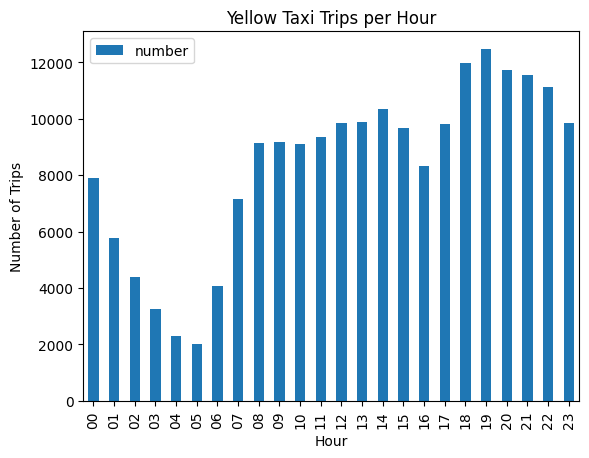

In [43]:
taxi_trip_by_hour()

### Visualization 2
This function shows the average distance traveled per month
In order to find this for both taxis and Ubers combined, we need to create two querys to get taxi and uber data seperatly from two tables. And include the 90% confidence interval around the mean in the visualization

In [44]:
QUERY_taxi = """SELECT strftime('%Y-%m', pickup_datetime) AS month, SUM(distance) AS distance
                FROM taxi_trips
                GROUP BY month
             """
QUERY_uber =  """SELECT strftime('%Y-%m', pickup_datetime) AS month, SUM(distance) AS distance
                FROM uber_trips
               GROUP BY month
             """

In [45]:
def average_distance_month():
    """
    This function plot average distance traveled per month and a 90% confidence interval for mean
    """
    # use the function read_sql_query to pull out values needed to plot and make it a dataframe
    df_taxi = pd.read_sql_query(QUERY_taxi, engine)
    df_uber = pd.read_sql_query(QUERY_uber, engine)
    
    df_taxi['month'] = pd.to_datetime(df_taxi['month'], format='%Y-%m')
    df_uber['month'] = pd.to_datetime(df_uber['month'], format='%Y-%m')

    taxi_info =df_taxi['distance'].groupby(df_taxi['month'].dt.month).agg(['mean','count','sem'])
    uber_info =df_uber['distance'].groupby(df_uber['month'].dt.month).agg(['mean','count','sem'])
    taxi_low, taxi_high = st.t.interval(0.90,taxi_info['count']-1 , loc=taxi_info['mean'], scale=taxi_info['sem'])
    uber_low, uber_high = st.t.interval(0.90, uber_info['count']-1, loc=uber_info['mean'], scale=uber_info['sem'])
    taxi_info['mean'].plot( color='orange', label='Taxi',ylabel = 'Average Distance')
    uber_info['mean'].plot( color='purple', label='Uber',ylabel = 'Average Distance')
    plt.fill_between(taxi_info.index, taxi_low, taxi_high, color='orange', alpha=0.2)
    plt.fill_between(uber_info.index, uber_low, uber_high, color='purple', alpha=0.2)
    plt.title('Average Distance per Month')
    plt.legend()

    plt.show()

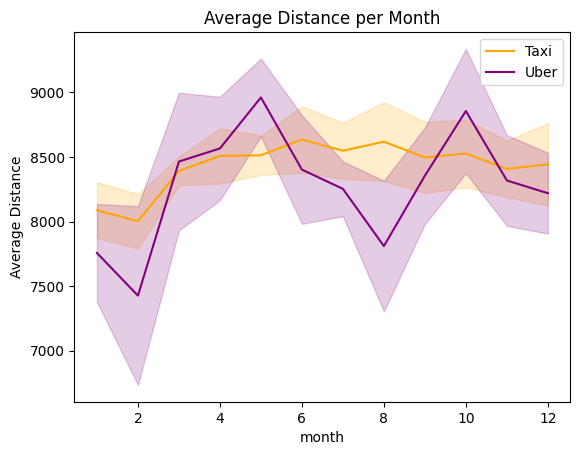

In [46]:
average_distance_month()

### Visualization 3

We found three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR.
Created a visualization that compares what day of the week was most popular for drop offs for each airport.


In [47]:
def most_pop_airport():
    """
    This function plot number of dropoff for each airport 
    """
    
    df = []
    EWR = [-74.192390,40.670047,-74.153337,40.707844,'EWR']
    JFK=  [ -73.823776,40.620946,-73.747559,40.665083,'JFK']
    LGA = [  -73.889329,40.766710,-73.854761,40.786449,'LGA']
    for place in [EWR,JFK,LGA]:
        query_place = f'''WITH trips AS (SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
                    UNION ALL SELECT pickup_datetime,dropoff_longitude,dropoff_latitude FROM uber_trips)

                        SELECT strftime('%w', pickup_datetime) AS day ,COUNT(*) AS {place[4]}
                        FROM trips
                        WHERE dropoff_longitude BETWEEN {place[0]} AND {place[2]} AND dropoff_latitude BETWEEN {place[1]} AND {place[3]}
                        GROUP BY day
              '''
        df.append(pd.read_sql_query(query_place, engine))
        
    JFK = df[1]['JFK']
    EWR =df[0]['EWR']
    LGA =df[2]['LGA']
    df[0]['JFK'] = df[1]['JFK']
    df[0]['LGA'] = df[2]['LGA']

    df[0].plot(x="day", y=['EWR','JFK','LGA'], kind="bar", title="Dropoffs for Each Airport in Each Day of a Week", xlabel="Day", ylabel="Number of Dropoffs")

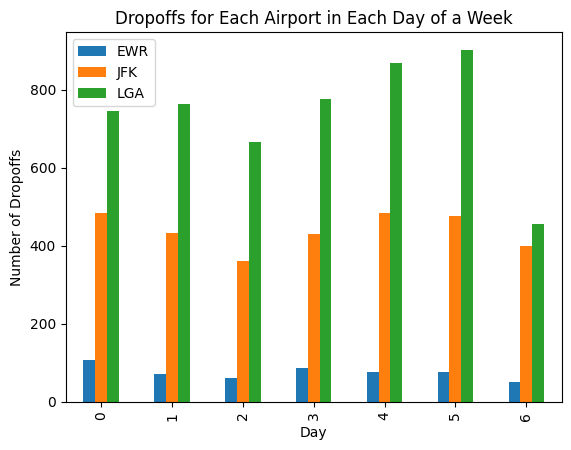

In [48]:
most_pop_airport()

### Visualization 4
Create a heatmap of all hired trips over a map of the area. 

In [49]:
def heatmap_trips():
    """
    This function create a heatmap of number of trips in the area 
    """
    
    query = '''SELECT pickup_longitude, pickup_latitude
               FROM taxi_trips
               UNION ALL
               SELECT pickup_longitude, pickup_latitude
               FROM uber_trips
            '''
    df = pd.read_sql_query(query, engine)
    zones = taxi_zones_df.copy()
    zones = zones[['LocationID','geometry']]
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))
    result = zones.sjoin(df, how='left')
    result = result.set_index('LocationID')
    result['num'] = result.groupby('LocationID')['geometry'].count()
    result['log_num'] = np.log(result['num'])
    result.plot(column='log_num', cmap='plasma', legend=True, legend_kwds={'label': "number of trips in different area"})
    plt.axis('off')
    plt.show()

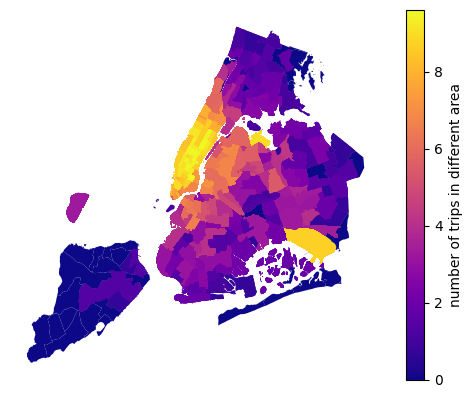

In [50]:
heatmap_trips()

### Visualization 5
CreateD a scatter plot that compares tip amount versus distance.

In [51]:
def tip_distance():
    """
    This function create a scatter plot for tip amount and distance 
    """

    QUERY = """ SELECT tip_amount,distance
                FROM taxi_trips      
            """
    df = pd.read_sql_query(QUERY, engine)

    # sample the data to make the scatter plot clearer
    df =df.sample(500)
    df = df[df['distance'] < 100]
    df =df[df['tip_amount'] > 0]
    df.plot(x="distance", y="tip_amount", kind="scatter", title="Tip Amount with Distance", xlabel="Distance", ylabel="Tip Amount")

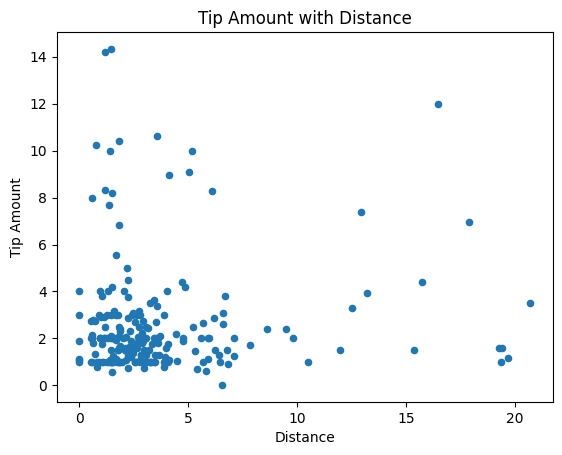

In [52]:
tip_distance()

### Visualization 6
Created another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [53]:
def tip_precipitation():
    """
    This function create a scatter plot for tip amount and precipitation 
    """
    query_tip ="""SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS DATE, tip_amount
                FROM taxi_trips
                """ 
    query_precipitation ="""SELECT strftime('%Y-%m-%d %H', datetime) as DATE, hourly_precipitation
                FROM hourly_weather
                """
    df_tip = pd.read_sql_query(query_tip, engine)
    df_precipitation =pd.read_sql_query(query_precipitation, engine)
    df = df_tip.merge(df_precipitation,on = 'DATE').sample(2000)
    df = df[df['hourly_precipitation'] >0]
    df =df[df['tip_amount'] > 0]
    df.plot(x="tip_amount", y="hourly_precipitation", kind="scatter", title="Tip Amount and Precipitation", 
            xlabel="Tip Amount", ylabel="Hourly Precipitation")

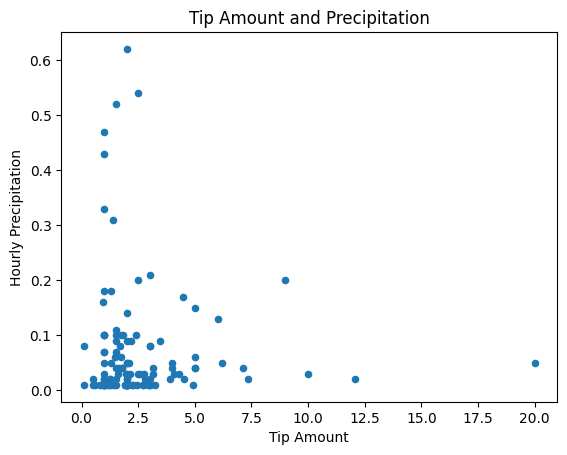

In [54]:
tip_precipitation()

### Visualization Sunrise and Sunset
Question: What is the total number of trips, mean distance of trips, total distance of trips, max distance of trips taken during the day and during the night?

We will use the pie chart and Interactive Control Widgets to show the ratio of trips taken during the day (between sunrise and sunset) and during the night (taken between sunset and sunrise).

In [55]:
def sunrise_sunset():    
    """
    This function read sun data and return a dataframe for Interactive Pie chart
    """

    # read data from the database
    query = """
               WITH hired_trips AS
               (SELECT date(pickup_datetime) AS date, pickup_datetime, distance
               FROM taxi_trips 
               UNION ALL
               SELECT date(pickup_datetime) AS date, pickup_datetime, distance
               FROM uber_trips)
               SELECT hired_trips.date, pickup_datetime, distance, sunrise, sunset
               FROM hired_trips
               LEFT JOIN sun_data
               ON hired_trips.date = sun_data.date
               """
    df = pd.read_sql_query(query, engine)

    # convert the date to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    
    # drop Nan Data
    df = df.dropna()
    df = df.astype({'sunrise':'int','sunset':'int'})
    
    # calculate the minutes from start of the day
    df['sunrise_minutes'] = df['sunrise'].map(lambda x: x // 100 * 60 + x % 100)
    df['sunset_minutes'] = df['sunset'].map(lambda x: x // 100 * 60 + x % 100)
    df['pickup_datetime_minutes'] = df['pickup_datetime'].map(lambda x: x.hour * 60 + x.minute)

    # find the trips that started during the day
    df['day_ride'] = (df['pickup_datetime_minutes'] > df['sunrise_minutes']) & (df['pickup_datetime_minutes'] < df['sunset_minutes'])
    
    # create a dataframe for Interactive Pie chart
    plot_df = pd.DataFrame({'time':['Day','Night']})
    plot_df['trip number'] = df.groupby(['day_ride'])['distance'].count()
    plot_df['mean distance'] = df.groupby(['day_ride'])['distance'].mean()
    plot_df['total distance'] = df.groupby(['day_ride'])['distance'].sum()
    plot_df['max distance'] = df.groupby(['day_ride'])['distance'].max()
    
    return plot_df

In [56]:
plot_df = sunrise_sunset()
@interact
def scatter_plot(x=['trip number', 'mean distance', 'total distance', 'max distance'],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    
    plot_df.iplot(kind='pie', values=x, title='Day and Night Trips', labels='time',
                  legend=True, theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('trip number', 'mean distance', 'total distance', 'ma…